In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

data = pd.read_csv('../input/netflix-shows/netflix_titles.csv')
ratings = pd.read_csv('../input/imdb-ratings-for-the-netflix-shows/IMDB_results_jan-28-2020.csv')
data = data.fillna('Unknown')
data.drop(['show_id','date_added'], axis=1, inplace=True)

# Which year is most shows released? ---> 2018

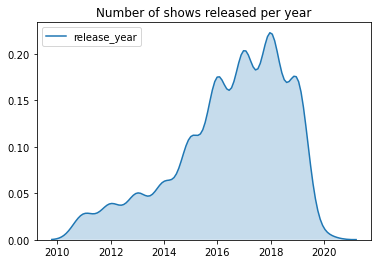

In [2]:
df = data[data['release_year']>2010]
sns.kdeplot(data=df['release_year'], label='release_year', shade=True)
plt.title('Number of shows released per year')
plt.show()

A major problem with this dataset is there is no metric on which I can compare other variables.

So in this case I will need to create a new metric.

For creating a metric the best option to compare is the 'rating' column.

Now a new problem that appears is that this variable is categorical and each of these rating have a different kind of meaning. First let's understand those meanings.

# Meanings of each rating

1. TV-MA - This program is specifically designed to be viewed by adults and therefore may be unsuitable for children under 17
2. TV-14 - This program contains some material that many parents would find unsuitable for children under 14 years of age
3. TV-PG - This program contains material that parents may find unsuitable for younger children
4. R     - Under 17 requires accompanying parent or adult guardian
5. PG-13 - Some material may be inappropriate for children under 13
6. NR    - Not rated
7. PG    - Some material may not be suitable for children
8. TV-Y7 - This program is designed for children age 7 and above
9. TV-G  - This program is suitable for all ages
10. TV-Y - This program is designed to be appropriate for all children
11. TV-Y7-FV - This program is designed for children age 7 and above containing some fantasy violence
12. G    - All ages admitted
13. UR   - Unrated
14. NC-17- No One 17 and Under Admitted

I just found a dataset with the IMDB ratings of the shows in this dataset from a separate script.

Script that produced the dataset: https://www.kaggle.com/aalhendi/netflix-movies-and-tv-shows-ratings

# Adding the IMDB rating column

In [3]:
data['IMDB_rating'] = ratings['IMDB_rating'].str.split().str[0].str.replace('Not','0.0')
data['Number of reviews'] = ratings['IMDB_rating'].str.split().str[3].str.replace(',','')
data['IMDB_rating'] = data['IMDB_rating'].astype('float')
data['Number of reviews'] = data['Number of reviews'].dropna().astype('int')
data = data.dropna()

I almost dropped a 100 columns, this wouldn't have been a good choice for using the data for finding patterns in it or applying ML models but since I am only doing analysis of the columns, it's better to drop them.

# Shows/movie with all time highest reviews ---> Inception

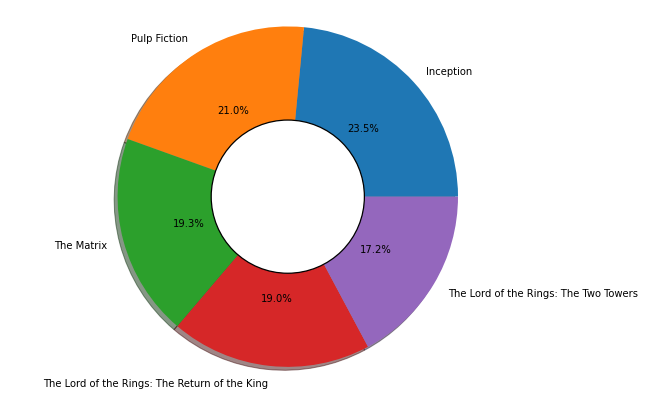

In [4]:
df = data.sort_values('Number of reviews', ascending=False)
df = df.head()

fig = plt.figure(figsize=(10,7))
plt.pie(df['Number of reviews'], labels=df['title'], autopct='%1.1f%%', shadow=True)
centre_circle = plt.Circle((0,0),0.45,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.show()

# IMDB Rating distribution ---> Highest density at 7

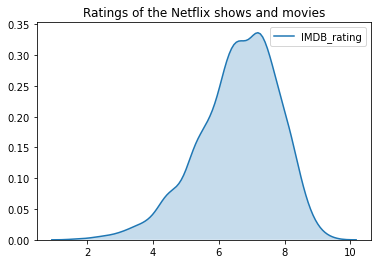

In [5]:
sns.kdeplot(data=data['IMDB_rating'], label='IMDB_rating', shade=True)
plt.title('Ratings of the Netflix shows and movies')
plt.show()